# Evaluation of GRN inference methods
## Supplementary analysis
### by Jalil Nourisa



# Imports

In [51]:
!cd ../ && source env.sh

Base directory set to: /Users/jno24/Documents/projs/ongoing
Wrote env.yaml


In [52]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import anndata as ad
import tqdm
import json
import warnings
import matplotlib
import sys
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import scanpy as sc 
import itertools
import warnings
import os
import warnings
from scipy import stats
warnings.filterwarnings("ignore") #all warnings
plt.rcParams['font.family'] = 'Arial' # Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

# - local imports (task_grn_inference should be along side this repo)
from grn_benchmark.src.helper import load_env
env = load_env()

# Check if env['GRN_BENCHMARK_DIR'] exists
if 'GRN_BENCHMARK_DIR' not in env:
    raise KeyError("GRN_BENCHMARK_DIR not found in environment variables")
if not os.path.exists(env['GRN_BENCHMARK_DIR']):
    raise FileNotFoundError(f"GRN_BENCHMARK_DIR path does not exist: {env['GRN_BENCHMARK_DIR']}")

sys.path.append(env['GRN_BENCHMARK_DIR'])
from src.helper import plot_heatmap, surrogate_names, custom_jointplot, palette_celltype, \
                       palette_methods, \
                       palette_datasets, colors_blind, linestyle_methods, palette_datasets, CONTROLS3, linestyle_methods, retrieve_grn_path, \
                        plot_raw_scores
from src.params import get_par

TASK_GRN_INFERENCE_DIR = env['TASK_GRN_INFERENCE_DIR']
sys.path.append(TASK_GRN_INFERENCE_DIR)
from src.utils.util import naming_convention
from src.utils.config import DATASETS, METRICS, METHODS, FINAL_METRICS
# from src.utils.util import 

# - ordered names
from pandas.api.types import CategoricalDtype
category_order_reg1 = CategoricalDtype(categories=['GRNBoost2', 'Scenic+', 'Positive Ctrl', 'Pearson Corr.', 'GRaNIE'], ordered=True)
category_order_reg2 = CategoricalDtype(categories=['GRNBoost2', 'Positive Ctrl', 'Pearson Corr.', 'PPCOR'], ordered=True)

# - variables
perturb_col = 'perturbation'

# - directories
RESULTS_DIR = env['RESULTS_DIR']
figs_dir = F"{env['RESULTS_DIR']}/figs"
os.makedirs(figs_dir, exist_ok=True)
%matplotlib inline

surrogate_names['gs_precision']


['Arial']


'GS (precision)'

# Metrics application

## Aging

In [ ]:
# - IL10 is known to be anti-inflammatory: get active tfs of il10 in aging -> better grn model provides better alignment with aging

## IBD disease

In [ ]:
!cd ../ && python src/stability_analysis/tf_recovery_disease_analysis.py \
    --model pearson_corr \
    --output_dir output/tf_recovery_disease_analysis \
    --cell_types 'MONO' --test_type limma

# !cd ../ && python src/stability_analysis/compare_tf_models.py --dataset ibd_cd --model1 pearson_corr --model2 grnboost --output_dir output/tf_recovery_disease_analysis/

# Ensemble

In [41]:
dataset = 'op'
rr_folder = f"{env['RESULTS_DIR']}/experiment/ensemble_genewise/{dataset}/"
os.makedirs(rr_folder, exist_ok=True)
!cd ../ && bash scripts/experiment_ensemble.sh --rr_folder {rr_folder} --dataset {dataset} --theta 0.25 --skip_metrics

Base directory set to: /home/jnourisa/projs/ongoing
Wrote env.yaml
Running gene-wise ensemble for dataset: op
Using theta (quantile): 0.25
Models to ensemble: ['scenicplus', 'grnboost', 'pearson_corr', 'ppcor']

STEP 3: Assembling ensemble network
Loading networks...
Original net shape:  (66059, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (65919, 3)
Network shape applying max_n_links: (50000, 3)
Original net shape:  (50000, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
Original net shape:  (50000, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
Original net shape:  (50000, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)

Ensemble network statistics:
  Total edges: 6345
  Unique target genes: 2778
  Unique source ge

In [42]:
dataset = 'replogle'
rr_folder = f"{env['RESULTS_DIR']}/experiment/ensemble_genewise/{dataset}/"
os.makedirs(rr_folder, exist_ok=True)
!cd ../ && bash scripts/experiment_ensemble.sh --rr_folder {rr_folder} --dataset {dataset} --theta 0.25 --skip_metrics

Base directory set to: /home/jnourisa/projs/ongoing
Wrote env.yaml
Running gene-wise ensemble for dataset: replogle
Using theta (quantile): 0.25
Models to ensemble: ['scenic', 'grnboost', 'pearson_corr', 'ppcor']

STEP 3: Assembling ensemble network
Loading networks...
Original net shape:  (21039, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (20968, 3)
Network shape applying max_n_links: (20968, 3)
Original net shape:  (50000, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
Original net shape:  (50000, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
Original net shape:  (50000, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)

Ensemble network statistics:
  Total edges: 11751
  Unique target genes: 3525
  Unique source

# TF masking analysis

In [41]:
# !cd ../ && sbatch scripts/experiment_causality.sh 
!cd ../ && python src/exp_analysis/post_tf_masking.py 

Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/consensus_regulators/causality_relative_performance.png


# Metrics overview

In [57]:
output_dir = f"{RESULTS_DIR}/experiment/metrics_applicibility"
!cd ../ && python src/stability_analysis/metrics_applicibility/script.py --cv_threshold 0.2 --output {output_dir} --local_run


Results saved to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/experiment/metrics_applicibility
Metrics summary saved to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/experiment/metrics_kept_per_dataset.yaml
                 Total  Keep      Keep %
dataset                                 
ibd_cd               5     5  100.000000
ibd_uc               5     5  100.000000
op                   7     7  100.000000
parsebioscience      7     7  100.000000
300BCG               7     6   85.714286
norman               7     6   85.714286
replogle            10     8   80.000000
xaira_HCT116        10     7   70.000000
nakatake             5     3   60.000000
xaira_HEK293T       10     5   50.000000

                  Metric                                                                                                                                             Summary                                                                    

# Gene sets recovery

In [ ]:
!cd {env['TASK_GRN_INFERENCE_DIR']} && bash src/metrics/experimental/gs_recovery/run_global.sh

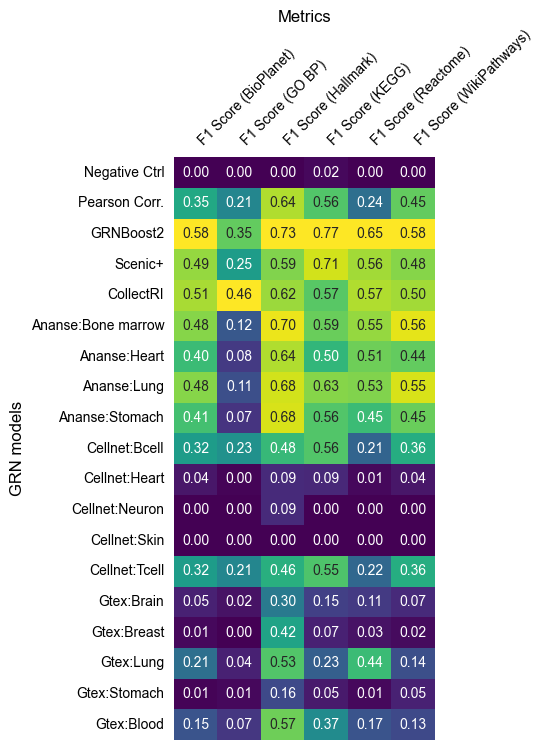

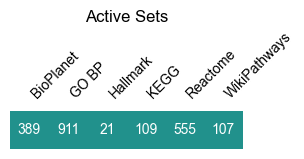

In [3]:
output_dir = f"{env['TASK_GRN_INFERENCE_DIR']}/resources/results/experiment/gs_recovery/"
metric = 'gs_recovery'
sets = ['reactome_2022', 'bioplanet_2019', 'wikipathways_2019', 'kegg_2021', 'go_bp_2023', 'hallmark_2020']

# Prettier names mapping
pretty_names = {
    'reactome_2022': 'Reactome',
    'bioplanet_2019': 'BioPlanet',
    'wikipathways_2019': 'WikiPathways',
    'kegg_2021': 'KEGG',
    'go_bp_2023': 'GO BP',
    'hallmark_2020': 'Hallmark'
}

# Method ordering: inferred GRNs first, then global ones
method_order = ['negative_control', 'pearson_corr', 'grnboost', 'scenicplus', 'collectri']

df_all = pd.read_csv(f'{output_dir}/summary_global.csv')
for dataset in df_all['dataset'].unique():
    df = df_all[df_all['dataset'] == dataset]
    df = df.pivot(index='method', columns='metric', values='value')
    
    # Collect columns by type
    precision_cols = [col for col in df.columns if 'gs_precision' in col]
    recall_cols = [col for col in df.columns if 'gs_recall' in col]
    active_cols = [col for col in df.columns if 'gs_n_active' in col]
    f1_cols = [col for col in df.columns if 'gs_f1' in col]
    
    # Main plot: precision and recall only
    cols_main =  f1_cols
    df_main = df[cols_main].copy()
    
    # Rename columns with prettier names
    new_col_names = {}
    for col in df_main.columns:
        source = col.replace('_gs_precision', '').replace('_gs_recall', '').replace('_gs_f1', '')
        pretty_source = pretty_names.get(source, source)
        if 'gs_precision' in col:
            new_col_names[col] = f'Precision ({pretty_source})'
        elif 'gs_recall' in col:
            new_col_names[col] = f'Recall ({pretty_source})'
        elif 'gs_f1' in col:
            new_col_names[col] = f'F1 Score ({pretty_source})'
    df_main = df_main.rename(columns=new_col_names)
    
    # Order methods: specified ones first, then the rest
    available_methods = df_main.index.tolist()
    ordered_methods = [m for m in method_order if m in available_methods]
    remaining_methods = [m for m in available_methods if m not in method_order]
    final_method_order = ordered_methods + remaining_methods
    df_main = df_main.reindex(final_method_order)
    df_main.index = df_main.index.map(lambda x: surrogate_names.get(x, x))
    
    # Plot main heatmap (precision and recall)
    fig, ax = plt.subplots(figsize=(.9*len(df_main.columns), .4*len(df_main)))
    plot_heatmap(df_main, name='',  cmap="viridis", ax=ax)
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('GRN models', fontsize=12)
    plt.tight_layout()
    
    # Separate plot for active sets (constant across methods)
    if active_cols:
        df_active = df[active_cols].copy()
        new_col_names_active = {}
        for col in df_active.columns:
            source = col.replace('_gs_n_active', '')
            pretty_source = pretty_names.get(source, source)
            new_col_names_active[col] = pretty_source
        df_active = df_active.rename(columns=new_col_names_active)
        
        # Take first row since it's constant
        df_active_display = df_active.iloc[:1]
        
        fig, ax = plt.subplots(figsize=(.5*len(df_active_display.columns), 0.5))
        df_active_display = df_active_display.astype(int)
        plot_heatmap(df_active_display, name='',  cmap="viridis", ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        plt.title(f'Active Sets')
        plt.tight_layout()


# TF binding

In [30]:
!ls {TASK_GRN_INFERENCE_DIR}/resources/datasets_raw/tfb

chipatlas  remap2022  unibind


In [8]:
!cd ../ && python src/exp_analysis/gt_analysis.py 

Processing cell type: PBMC
  remap2022: 12 TFs, 42917 edges, 13300 targets
  chipatlas: 59 TFs, 56695 edges, 13178 targets
  remap2022: 12 TFs, 42917 edges, 13300 targets
  chipatlas: 59 TFs, 56695 edges, 13178 targets
  unibind: 46 TFs, 166947 edges, 16164 targets
Processing cell type: K562
  unibind: 46 TFs, 166947 edges, 16164 targets
Processing cell type: K562
  remap2022: 261 TFs, 1087856 edges, 17427 targets
  remap2022: 261 TFs, 1087856 edges, 17427 targets
  chipatlas: 336 TFs, 283874 edges, 14857 targets
  chipatlas: 336 TFs, 283874 edges, 14857 targets
  unibind: 86 TFs, 307451 edges, 16777 targets
Processing cell type: HEK293
  unibind: 86 TFs, 307451 edges, 16777 targets
Processing cell type: HEK293
  remap2022: 404 TFs, 1037668 edges, 17572 targets
  remap2022: 404 TFs, 1037668 edges, 17572 targets
  chipatlas: 276 TFs, 131309 edges, 14668 targets
  chipatlas: 276 TFs, 131309 edges, 14668 targets
  unibind: 41 TFs, 177850 edges, 16171 targets
Processing cell type: HCT116
 

## Scores global

In [15]:
!cd {env['TASK_GRN_INFERENCE_DIR']} && sbatch src/metrics/tf_binding/run_global.sh

Submitted batch job 9198945


In [17]:
!sacct

JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 
9189131          vscode        gpu       biim         20    RUNNING      0:0 
9189131.bat+      batch                  biim         20    RUNNING      0:0 
9189131.ext+     extern                  biim         20    RUNNING      0:0 
9198942      bulk_vs_sc        cpu       biim         20    RUNNING      0:0 
9198942.bat+      batch                  biim         20    RUNNING      0:0 
9198942.ext+     extern                  biim         20    RUNNING      0:0 
9198945      tf_bindin+        cpu       biim         20    RUNNING      0:0 
9198945.bat+      batch                  biim         20    RUNNING      0:0 
9198945.ext+     extern                  biim         20    RUNNING      0:0 


In [ ]:
!ls -lt {env['TASK_GRN_INFERENCE_DIR']}/resources/results/experiment/tf_binding/

total 72
-rw-r--r-- 1 jnourisa clusers 519 Nov 21 15:01 summary_global.csv
drwxr-xr-x 2 jnourisa clusers 751 Nov 20 14:24 tmp


,dataset,method,tfb_grn,tfb_all,unibind_tfb_grn_norm,unibind_tfb_all_norm,chipatlas_tfb_grn_norm,chipatlas_tfb_all_norm,remap_tfb_grn_norm,remap_tfb_all_norm
0,op,Ananse:Bone marrow,0.102873,0.035740,0.136198,0.041452,0.058165,0.018731,0.194948,0.097474
1,op,Ananse:Heart,0.024480,0.005472,0.041997,0.010043,0.008129,0.001102,0.037726,0.009432


In [18]:
# TF Binding Analysis
output_dir = f"{env['TASK_GRN_INFERENCE_DIR']}/resources/results/experiment/tf_binding/"
metric = 'tf_binding'

# Ground truth sources
gt_sources = ['unibind', 'chipatlas', 'remap']

# Prettier names mapping for GT sources
gt_pretty_names = {
    'unibind': 'UniBind',
    'chipatlas': 'ChIP-Atlas',
    'remap': 'ReMap'
}

# Method ordering: inferred GRNs first, then global ones
method_order = ['negative_control', 'pearson_corr', 'grnboost', 'scenicplus', 'collectri']

df_all = pd.read_csv(f'{output_dir}/summary_global.csv')

for dataset in df_all['dataset'].unique():
    df = df_all[df_all['dataset'] == dataset].copy()
    df = df.set_index('method')
    
    # Calculate F1 score from precision (tfb_grn_norm) and recall (tfb_all_norm)
    df_f1 = pd.DataFrame(index=df.index)
    df_precision_recall = pd.DataFrame(index=df.index)
    
    for gt in gt_sources:
        precision_col = f'{gt}_tfb_grn_norm'
        recall_col = f'{gt}_tfb_all_norm'
        
        if precision_col in df.columns and recall_col in df.columns:
            precision = df[precision_col].astype(float)
            recall = df[recall_col].astype(float)
            
            # F1 = 2 * (precision * recall) / (precision + recall)
            # Handle division by zero
            f1 = 2 * (precision * recall) / (precision + recall)
            f1 = f1.fillna(0)  # If both precision and recall are 0
            
            pretty_gt = gt_pretty_names.get(gt, gt)
            df_f1[f'F1 ({pretty_gt})'] = f1
            df_precision_recall[f'Precision ({pretty_gt})'] = precision
            df_precision_recall[f'Recall ({pretty_gt})'] = recall
    
    # Order methods: specified ones first, then the rest
    available_methods = df_f1.index.tolist()
    ordered_methods = [m for m in method_order if m in available_methods]
    remaining_methods = [m for m in available_methods if m not in method_order]
    final_method_order = ordered_methods + remaining_methods
    
    # Prepare F1 dataframe
    df_f1 = df_f1.reindex(final_method_order)
    df_f1.index = df_f1.index.map(lambda x: surrogate_names.get(x, x))
    
    # Prepare Precision/Recall dataframe and sort columns
    df_precision_recall = df_precision_recall.reindex(final_method_order)
    df_precision_recall.index = df_precision_recall.index.map(lambda x: surrogate_names.get(x, x))
    # Sort columns: all precision first, then all recall
    precision_cols = [col for col in df_precision_recall.columns if 'Precision' in col]
    recall_cols = [col for col in df_precision_recall.columns if 'Recall' in col]
    df_precision_recall = df_precision_recall[precision_cols + recall_cols]
    
    # Plot F1 heatmap
    fig, ax = plt.subplots(figsize=(1*len(df_f1.columns), .4*len(df_f1)))
    plot_heatmap(df_f1, name='',  cmap="viridis", ax=ax)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)

    
    # Plot Precision and Recall heatmap
    fig, ax = plt.subplots(figsize=(1*len(df_precision_recall.columns), .4*len(df_precision_recall)))
    plot_heatmap(df_precision_recall, name='',  cmap="viridis", ax=ax)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)

    
    # Separate plot for TF coverage (number of TFs in GT and evaluated)
    # Get TF coverage columns (number of TFs, not percentage)
    n_tfs_in_gt_cols = [col for col in df.columns if 'n_tfs_in_gt' in col]
    n_tfs_evaluated_cols = [col for col in df.columns if 'n_tfs_evaluated' in col]
    
    if n_tfs_in_gt_cols or n_tfs_evaluated_cols:
        coverage_data = pd.DataFrame(index=df.index)
        
        # Add TFs in ground truth
        for gt in gt_sources:
            col = f'{gt}_n_tfs_in_gt'
            if col in df.columns:
                pretty_gt = gt_pretty_names.get(gt, gt)
                coverage_data[f'{pretty_gt} (in GT)'] = df[col].astype(float)
        
        # Add TFs evaluated (available in GRN)
        for gt in gt_sources:
            col = f'{gt}_n_tfs_evaluated'
            if col in df.columns:
                pretty_gt = gt_pretty_names.get(gt, gt)
                coverage_data[f'{pretty_gt} (in GRN)'] = df[col].astype(float)
        
        if not coverage_data.empty:
            coverage_data = coverage_data.reindex(final_method_order)
            coverage_data.index = coverage_data.index.map(lambda x: surrogate_names.get(x, x))
            fig, ax = plt.subplots(figsize=(.8*len(coverage_data.columns), .4*len(coverage_data)))
            plot_heatmap(coverage_data, name='',  cmap="plasma", ax=ax)
            ax.set_xlabel('', fontsize=12)
            ax.set_ylabel('', fontsize=12)

EmptyDataError: No columns to parse from file

# GB vs ridge in metrics

### Runs

In [5]:
reg_type = 'GB'  # 'ridge'
dataset = 'op'
net_folder = RESULTS_DIR.split('task_grn_inference')[1].replace('resources', '').strip('/')
publish_dir = f"s3://openproblems-data/resources/grn/{net_folder}"
save_dir = F"{publish_dir}/experiment/gb_vs_ridge/"
publish_dir

's3://openproblems-data/resources/grn/results'

In [6]:
!cd {TASK_GRN_INFERENCE_DIR} && bash scripts/run_grn_evaluation.sh --dataset={dataset} --run_local=false --reg_type={reg_type} --save_dir={save_dir} --build_images=false 


DATASET: op
PREDICTION: none
RUN_TEST: false
BUILD_IMAGES: false
RUN_LOCAL: false
reg_type: GB
Publish dir: s3://openproblems-data/resources/grn/results/experiment/gb_vs_ridge/
Generating dataset configuration...
Config file generated at: src/utils/dataset_config.env
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]


op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
op PBMC [regression,vc,rc_tf_act,tf_binding,sem,gs_recovery]
Available methods:
celloracle
figr
geneformer
granie
grnboost
negative_control
pearson_corr
portia
positive_control
scenic
scenicplus
scglue
scgpt

### Post

In [ ]:
# !aws s3 sync {save_dir} {RESULTS_DIR}/experiment/gb_vs_ridge/ --no-sign-request

download: s3://openproblems-data/resources/grn/results/experiment/gb_vs_ridge/score_uns.yaml to ../../task_grn_inference/resources/results/experiment/gb_vs_ridge/score_uns.yaml
download: s3://openproblems-data/resources/grn/results/experiment/gb_vs_ridge/trace.txt to ../../task_grn_inference/resources/results/experiment/gb_vs_ridge/trace.txt
download: s3://openproblems-data/resources/grn/results/experiment/gb_vs_ridge/metric_configs.yaml to ../../task_grn_inference/resources/results/experiment/gb_vs_ridge/metric_configs.yaml


In [9]:
from src.helper import read_yaml
scores_gb = read_yaml(f"{RESULTS_DIR}/experiment/gb_vs_ridge/score_uns.yaml").set_index('model').drop(columns=['dataset'])
scores_ridge = read_yaml(f"{RESULTS_DIR}/op/score_uns.yaml").set_index('model').drop(columns=['dataset'])

[{'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'figr', 'metric_ids': ['replica_consistency_precision', 'replica_consistency_balanced'], 'metric_values': [1.0128060022168346, 7.489606690132838]}, {'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'scprint', 'metric_ids': ['key', 'value'], 'metric_values': ['None', 'None']}, {'dataset_id': 'None', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'portia', 'metric_ids': ['key', 'value'], 'metric_values': ['None', 'None']}, {'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'granie', 'metric_ids': ['key', 'value'], 'metric_values': ['None', 'None']}, {'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'scglue', 'metric_ids': ['key', 'value'], 'metric_values': ['None', 'None']}, {'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'scprint', 'metric_ids': ['sem_p

In [ ]:
scores_gb = scores_gb[['r2-theta-0.1', 'r2-theta-0.5', 'r2-theta-1.0']]
scores_ridge = scores_ridge[['r2-theta-0.1', 'r2-theta-0.5', 'r2-theta-1.0']]

[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, ''),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, ''),
 Text(0, 10.5, ''),
 Text(0, 11.5, '')]

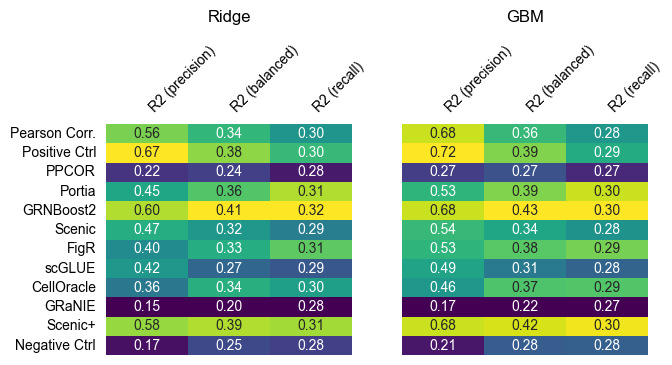

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=False)
ax = axes[0]
plot_raw_scores(scores_ridge, ax)
ax.set_xlabel('')
ax.set_title('Ridge', pad=15, weight='bold')

ax = axes[1]
plot_raw_scores(scores_gb, ax)
ax.set_title('GBM', pad=15, weight='bold')
ax.set_xlabel('')
ax.set_yticklabels([])

## Post

In [ ]:
# - GB vs ridge
scores_mat_ridge = pd.read_csv(f'', index_col=0)
scores_mat_GB = pd.read_csv(f'', index_col=0)

scores_mat_n = scores_mat_GB/scores_mat_ridge
scores_mat_n = scores_mat_n.drop(['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
def plot_gb_vs_ridge(ax):
    import seaborn as sns
    scores_mat_n_all_long = scores_mat_n.reset_index().melt(id_vars='index')
    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surrogate_names)
    scores_mat_n_all_long['variable'] = scores_mat_n_all_long['variable'].map(surrogate_names)

    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].astype(category_order)
    scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Relative performance \n (GB to Ridge)')
    # ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.1, .1), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
plot_gb_vs_ridge(ax)
fig.savefig(f"{results_folder}/figs/gb_vs_ridge.png", dpi=300, transparent=True, bbox_inches='tight')

# Normalization effect

### Run

In [ ]:
# !cd ../ && sbatch scripts/experiment_normalization.sh op

Submitted batch job 9103080


### Post analysis

In [31]:
!cd ../ && python src/exp_analysis/post_normalization.py --dataset op

Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/consensus_regulators/normalization_ranking_comparison.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/consensus_regulators/normalization_ranking_comparison_selected.png


# Permutation analysis

### Run

In [14]:
!cd ../ && sbatch scripts/experiment_permutation.sh replogle
!cd ../ && sbatch scripts/experiment_permutation.sh xaira_HEK293T
!cd ../ && sbatch scripts/experiment_permutation.sh op
!cd ../ && sbatch scripts/experiment_permutation.sh parsebioscience

Submitted batch job 9199275
Submitted batch job 9199276
Submitted batch job 9199276
Submitted batch job 9199277
Submitted batch job 9199277
Submitted batch job 9199278
Submitted batch job 9199278


### Post

#### functions

Saving figure to: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_link_all_replogle_raw.png
Saving figure to: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_link_all_xaira_HEK293T_raw.png
Saving figure to: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_link_all_op_raw.png
Saving figure to: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_link_all_parsebioscience_raw.png


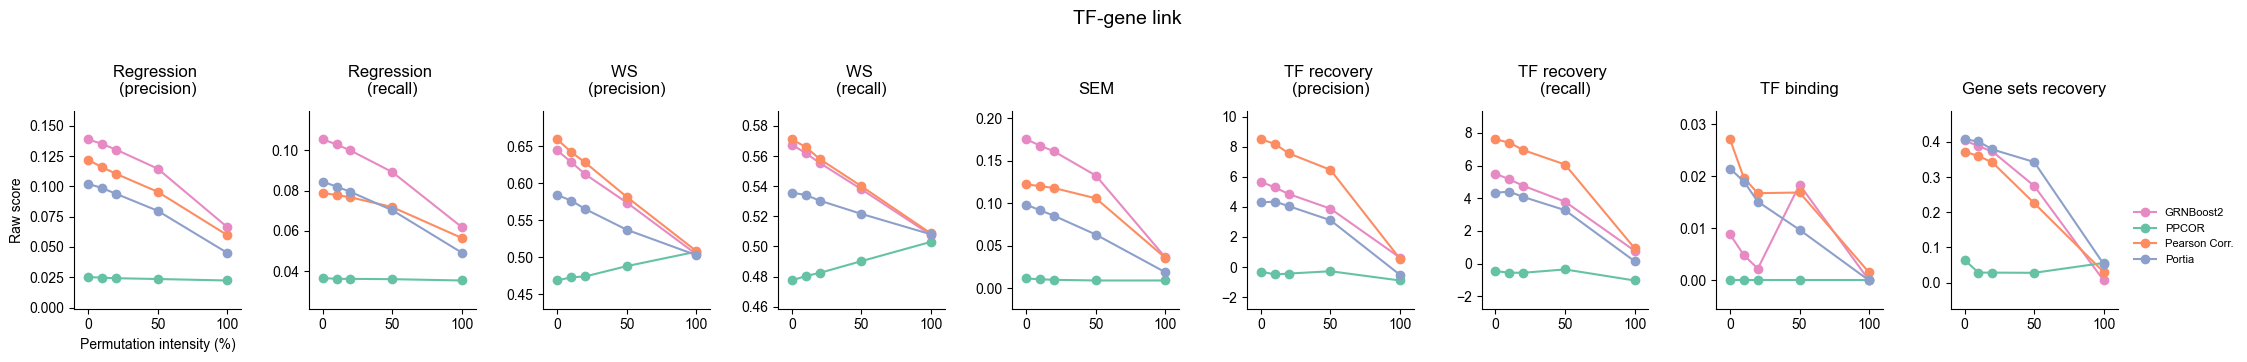

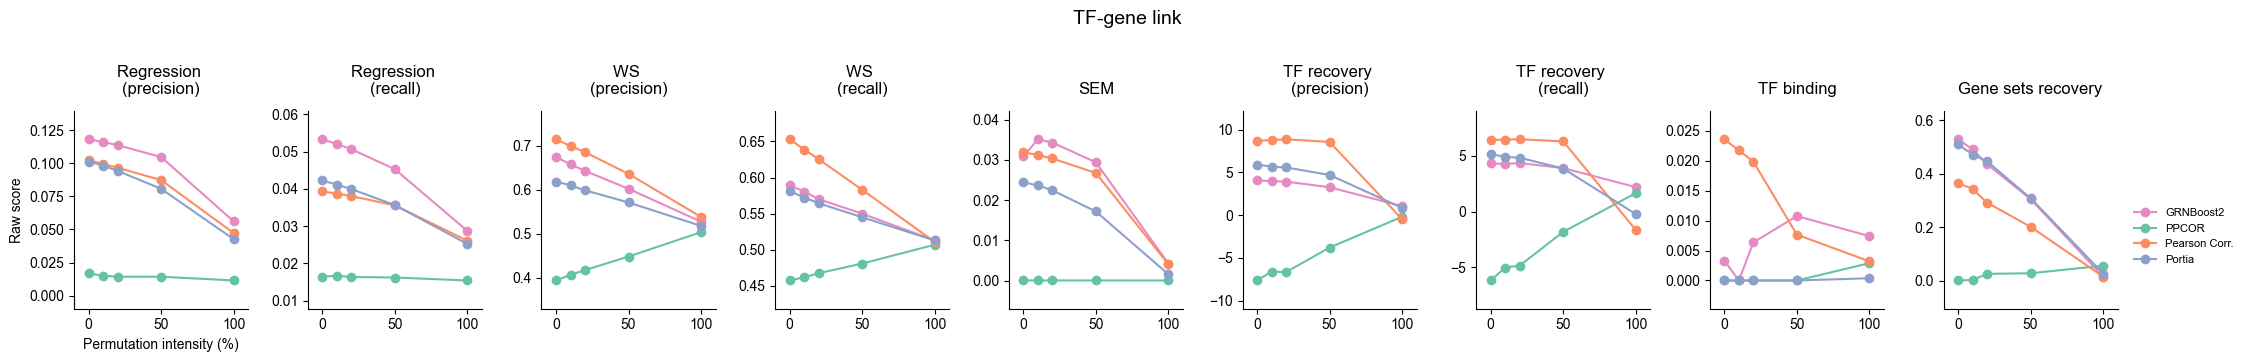

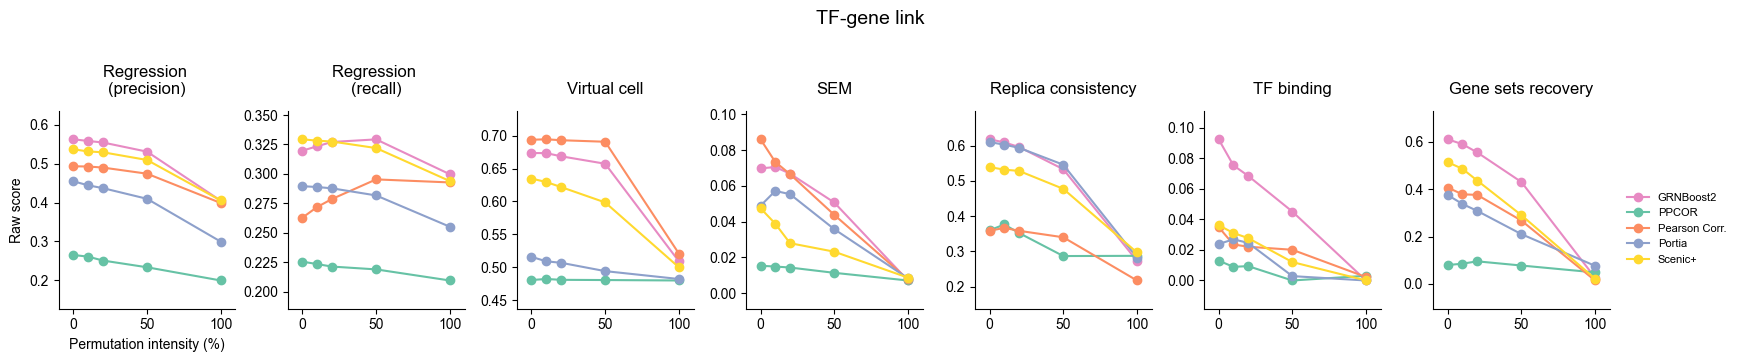

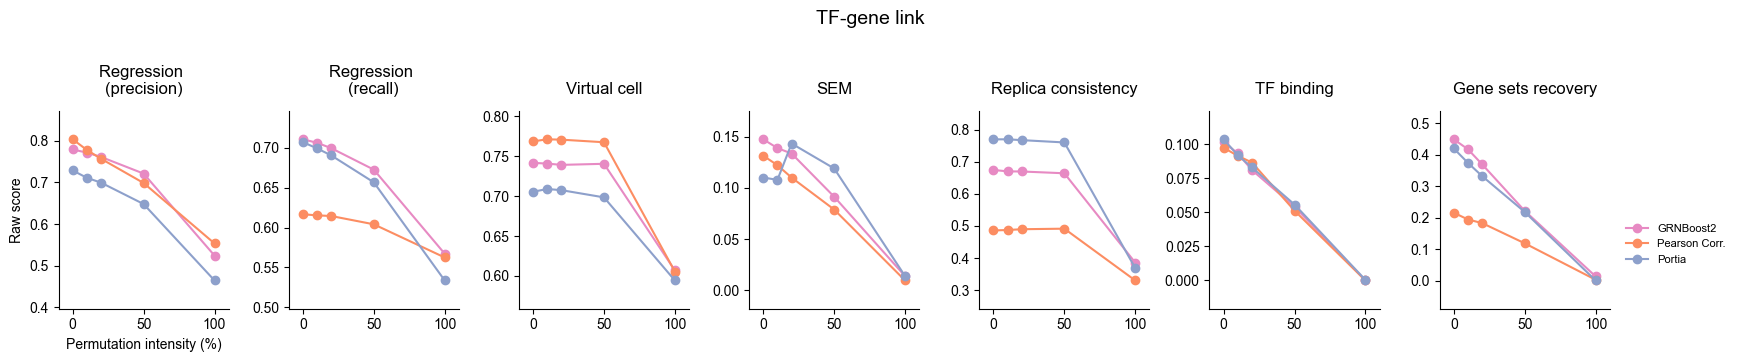

In [3]:
from src.exp_analysis.post_permutation import main as main_permut, plot_metrics_as_axes
# plot_metrics_as_axes(['r_precision', 'r_recall', 't_rec_precision', 't_rec_recall'], dataset='replogle', save_tag='selected')
plot_metrics_as_axes(METRICS, dataset='replogle', save_tag='all', use_raw_scores=True)
plot_metrics_as_axes(METRICS, dataset='xaira_HEK293T', save_tag='all', use_raw_scores=True)
plot_metrics_as_axes(METRICS, dataset='op', save_tag='all', use_raw_scores=True)
plot_metrics_as_axes(METRICS, dataset='parsebioscience', save_tag='all', use_raw_scores=True)

# Imputation analysis

In [5]:
dataset = 'op'
os.makedirs(f"{RESULTS_DIR}/experiment/imputation/", exist_ok=True)

### Run

In [31]:
!cd ../ && sbatch scripts/experiment_imputation.sh $dataset 

Submitted batch job 9198830


In [25]:
!ls -lt {RESULTS_DIR}/experiment/imputation/

total 5738848
-rw-r--r-- 1 jnourisa clusers        770 Dec 17 14:22 metrics_op.csv
-rw-r--r-- 1 jnourisa clusers      23048 Dec 17 14:22 op_magic_pearson_corr_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers      23048 Dec 17 14:15 op_knn_pearson_corr_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers      23048 Dec 17 14:09 op_original_pearson_corr_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers      20048 Nov 21 09:26 op_knn_grnboost_prediction.h5ad
-rw-r--r-- 1 jnourisa clusers    7260952 Nov 21 09:03 op_original_pearson_corr_prediction.h5ad
-rw-r--r-- 1 jnourisa clusers      23048 Nov 18 12:58 op_original_grnboost_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers        918 Oct 31 09:42 metrics_op_pearson_corr.csv
-rw-r--r-- 1 jnourisa clusers    7211800 Sep  7 19:46 op_original_grnboost_prediction.h5ad
-rw-r--r-- 1 jnourisa clusers 3123867748 Sep  6 17:31 op_magic_rna.h5ad
-rw-r--r-- 1 jnourisa clusers 1734404368 Sep  6 17:28 op_knn_rna.h5ad
-rw-r--r-- 1 jnourisa clusers

### Post

In [6]:
rr = pd.read_csv(f"{RESULTS_DIR}/experiment/imputation/metrics_{dataset}.csv")
names = rr['prediction'].str.split('/').str[-1].values
names = [f.split('_')[1] for f in names]
rr['prediction'] = names
rr.set_index('prediction', inplace=True)
mapping_ = { 
    'original':'Single-cell', 'magic': 'Magic imput.', 'knn': 'KNN imput.'
}
rr.index = rr.index.map(mapping_)
rr = rr[[m for m in FINAL_METRICS if m in rr.columns]]
rr.columns = rr.columns.map(lambda name: surrogate_names.get(name, name))
rr 


,Regression (precision),Regression (recall),Virtual cell,SEM
prediction,,,,
Single-cell,0.486960,0.273056,0.692327,0.086664
KNN imput.,0.229289,0.223197,0.387350,0.018636
Magic imput.,0.472394,0.280572,0.656994,0.070466


Saving figure to /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/imputation_performance.png


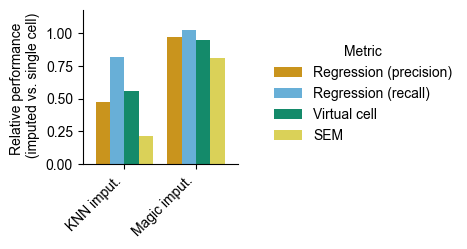

In [8]:
single_cell_row = rr.loc['Single-cell']
def plot_imput_vs_singlecell(ax):
    normalized_df = rr.div(single_cell_row, axis=1)
    normalized_df.drop('Single-cell', inplace=True)
    scores_mat_n_all_long = normalized_df.reset_index().melt(id_vars='prediction')
    sns.barplot(scores_mat_n_all_long, x='prediction', y='value', hue='variable', ax=ax, palette=colors_blind)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(r'Relative R$^2$ scores')
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharey=False)
plot_imput_vs_singlecell(ax)
ax.get_legend().remove()
ax.set_ylabel('Relative performance \n (imputed vs. single cell)')
ax.margins(x=.1)
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc=(1.2, .1), title='Metric', frameon=False)
file_name = f'{figs_dir}/imputation_performance.png'
print(f"Saving figure to {file_name}")
fig.savefig(file_name, dpi=300, transparent=True, bbox_inches='tight')

# Global nets

### Get global nets

In [ ]:
# !cd ../ && python src/process_data/pereggrn/acquisition.py 

### Run

In [15]:
!cd ../ && sbatch scripts/experiment_global_grns.sh op
!cd ../ && sbatch scripts/experiment_global_grns.sh parsebioscience
!cd ../ && sbatch scripts/experiment_global_grns.sh 300BCG
!cd ../ && sbatch scripts/experiment_global_grns.sh ibd_cd
!cd ../ && sbatch scripts/experiment_global_grns.sh ibd_uc

Submitted batch job 9199280


Submitted batch job 9199281
Submitted batch job 9199282
Submitted batch job 9199282
Submitted batch job 9199283
Submitted batch job 9199283
Submitted batch job 9199284
Submitted batch job 9199284


### Post

In [54]:
!cd .. && python src/exp_analysis/post_global.py --dataset op
!cd .. && python src/exp_analysis/post_global.py --dataset parsebioscience
!cd .. && python src/exp_analysis/post_global.py --dataset 300BCG
!cd .. && python src/exp_analysis/post_global.py --dataset ibd_cd
!cd .. && python src/exp_analysis/post_global.py --dataset ibd_uc

/Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/global_models_op.png
/Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/global_models_parsebioscience.png
/Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/global_models_300BCG.png
/Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/global_models_ibd_cd.png
/Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/global_models_ibd_uc.png


# Analysis of pseudobulking

### Granular

In [42]:
# !cd ../ && sbatch scripts/experiment_granular.sh
!cd ../ && python src/exp_analysis/post_granular.py

   Regression (precision)  Regression (recall)  ...       SEM  granularity
0                0.493073             0.262954  ...  0.086057         -1.0
1                0.315801             0.232867  ...  0.038961          1.0
2                0.295176             0.231211  ...  0.034725          3.0
3                0.288129             0.229140  ...  0.034375          5.0
4                0.306139             0.233153  ...  0.036739          7.0

[5 rows x 5 columns]
/Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/evaluation_scores_imputation_lineplot.png


## Bulk vs sc

In [44]:
# !cd ../ && sbatch scripts/experiment_sc_vs_bulk.sh
!cd ../ && python src/exp_analysis/post_sc_vs_bulk.py

Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/evaluation_scores_sc_vs_bulk_barplot.png


# Datasets stats

In [39]:
from src.exp_analysis.post_datasets_stats import main_datasets_stats, main_gene_wise, main_perturbation_effects
main_datasets_stats()

Loading cached stats from /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/datasets_stats_cache.csv
Unique perturbs:  26616
Cell count:  292683948313917881749430516411427958390627105908988685
Perturb type:  7
Cell type:  5
dataset summary table:  /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/datasets_stats/table_datasets_summary.png
dataset summary table:  /Users/jno24/Documents/projs/ongoing/task_grn_inference/docs/source/images/table_datasets_summary.png
dataset summary table short:  /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/datasets_stats/table_datasets_summary_short.pdf


### Gene wise evaluation

In [12]:
# main_gene_wise()

### Sample wise evaluation

perturbation_effects_all_datasets  /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/datasets_stats/perturbation_effects_all_datasets.png


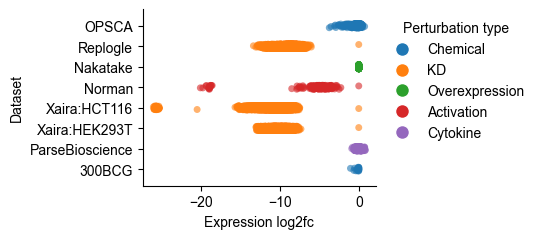

In [15]:
main_perturbation_effects()

# Metrics consensus stats

In [25]:
from src.exp_analysis.post_consensus_stats import main_consensus_regression, main_ws
main_consensus_regression()

regression_consensus_all: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/consensus_regulators/regression_consensus_all.png
regression_genes_with_regulators: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/consensus_regulators/regression_genes_with_regulators.png


In [17]:
main_ws()

ws_consensus_all: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/consensus_regulators/ws_consensus_all.png


# Metrics piece-wise analysis
Analysis for OP and replogle.
Set to replogle if WS distance is evaluated.

## Regression

In [34]:
from src.exp_analysis.post_piecewise import config_regression, wrapper_regression_feature_analysis, wrapper_plot_regression
dataset, gene_wise_output, gene_wise_feature_importance = config_regression()

In [ ]:
# !cd .. && sbatch scripts/experiment_metrics_stability.sh --dataset op --gene_wise_output {gene_wise_output}
# !cd .. && sbatch scripts/experiment_metrics_stability.sh --dataset op --gene_wise_feature_importance {gene_wise_feature_importance}

Submitted batch job 9197441


Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/lowess_nreg_vs_r2.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/model_comparison_regression_thetas.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/model_comparison_regression_raw.png


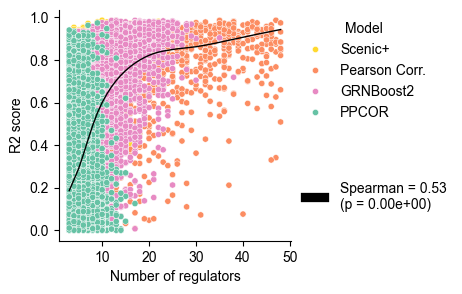

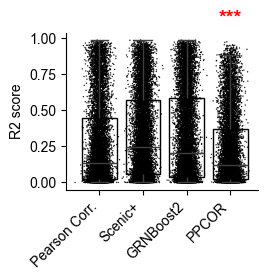

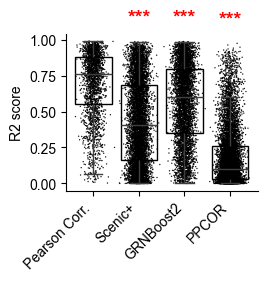

In [35]:
wrapper_plot_regression(gene_wise_output)

Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/reg_feature_importance_stability_op_0.25.png
{True: '#E69F00', False: '#56B4E9'}
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/reg2_nregulators_vs_r2scoes_op_0.25.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/reg2_scores_similarity_donors_op_0.25.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/reg2_models_corr_op_0.25.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/reg2_joint_tfactivity_vs_r2scores_op_0.25.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/reg_feature_importance_stability_op_0.75.png
{True: '#E69F00', False: '#56B4E9'}
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/reg2_nreg

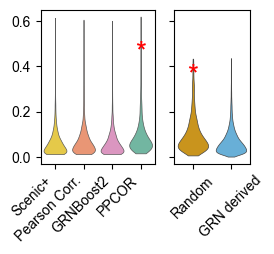

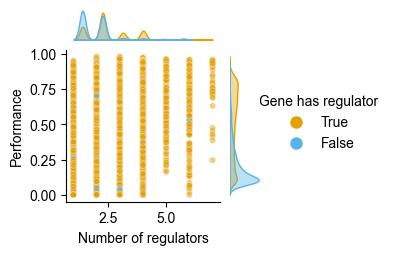

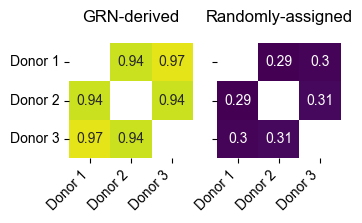

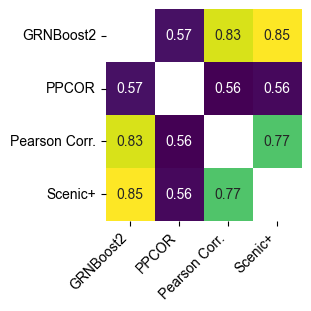

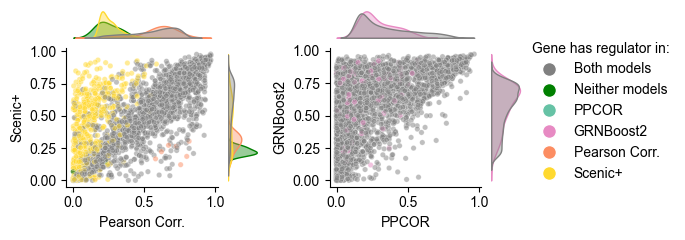

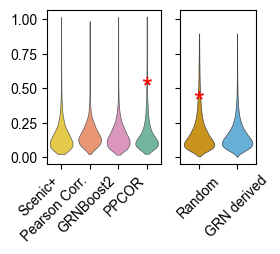

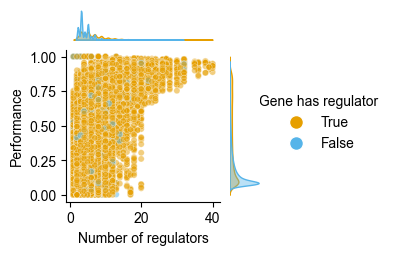

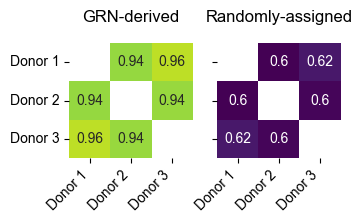

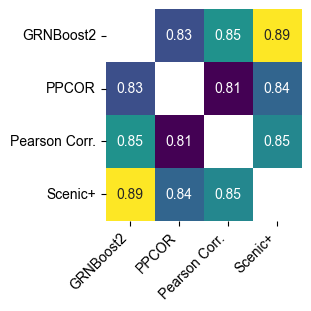

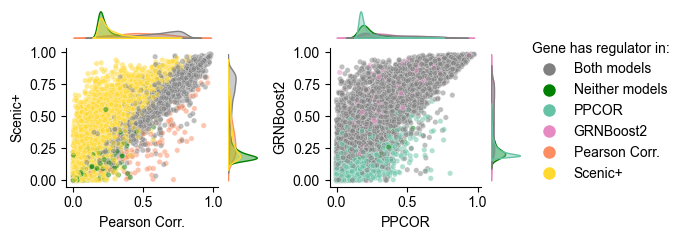

In [36]:
wrapper_regression_feature_analysis(dataset, gene_wise_feature_importance)

## WS distance

In [37]:
from src.exp_analysis.post_piecewise import config_ws, wrapper_ws_analysis
dataset, ws_output = config_ws()

In [ ]:
# !cd .. && sbatch scripts/experiment_metrics_stability.sh --dataset replogle  --ws_output {ws_output}

Submitted batch job 9102217


Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/ws_models_corr_WS_raw.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/ws_models_corr_0.25.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/ws_models_corr_0.75.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/ws_vs_perturbation_effect_replogle.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/ws_distance_comparision_replogle.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/ws_distance_normalized_comparision_replogle.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/ws_joint_tfwise_scores_replogle.png


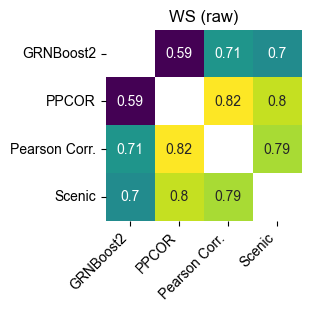

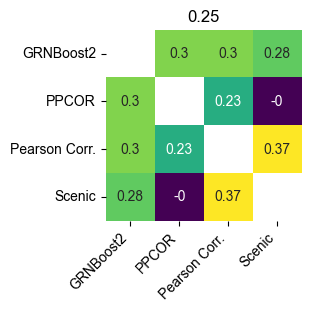

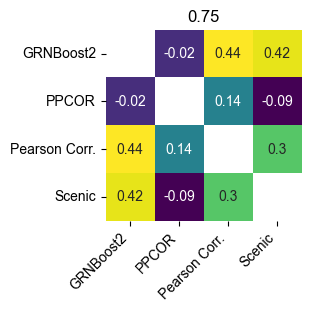

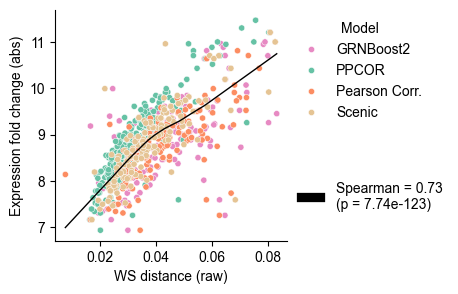

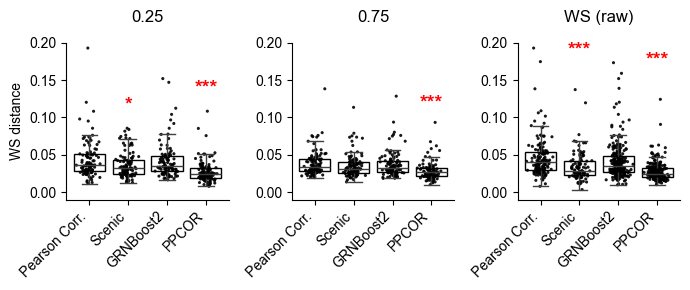

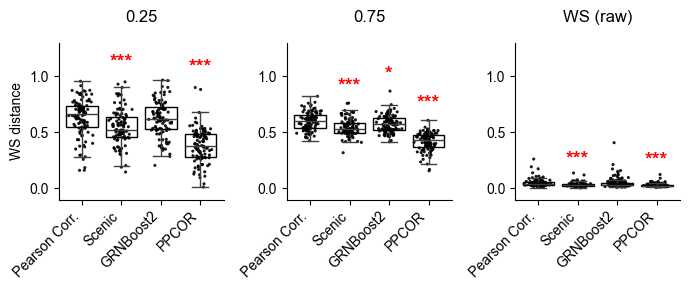

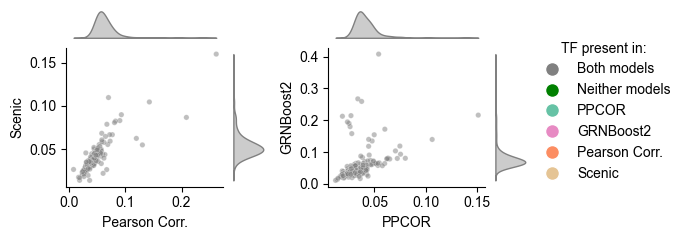

In [38]:
wrapper_ws_analysis(dataset, ws_output)

In [ ]:
aaa

# Topological analysis

### Create peak gene edges

In [ ]:
if False:  # scenicplus extended grn
    net = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/results/op/output/sp_grn_extended.csv', index_col=0)
    net = net[['peak', 'target']].drop_duplicates().reset_index(drop=True)
    net.to_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/peak_gene/scenicplus.csv')
if False: # figr extended grn
    net = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/results/op/output/figr_peak_gene.csv', index_col=0)
    net = net[['PeakRanges', 'Gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/peak_gene/figr.csv')
if False: # granie extended grn
    net = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/peak_gene/granie_extended.csv')
    net = net[['peak', 'gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/peak_gene/granie.csv')

In [33]:
!cd ../ && python src/exp_analysis/post_topology.py

dict_keys(['op', 'nakatake'])
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/topology_stats.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/topology_stats_1.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/topology_stats_2.png
Saving figure to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/jaccard_similarity_op.png


# CRE annoation

In [27]:
!ls {TASK_GRN_INFERENCE_DIR}/resources/grn_models/op/peak_gene

ls: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/grn_models/op/peak_gene: No such file or directory


In [ ]:
exp_objs_multiomics_dict = {}

for model in ['celloracle','scenicplus', 'figr', 'granie']:
    grn_model = f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/{dataset}/{model}.h5ad'
    peak_gene_net = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/op/peak_gene/{model}.csv')
    
    net = ad.read_h5ad(grn_model)
    net = net.uns['prediction']
    net['weight'] = net['weight'].astype(float)

    print(model, len(net))
    obj = Exp_analysis(net, peak_gene_net=peak_gene_net)
    obj.calculate_basic_stats()
    exp_objs_multiomics_dict[model] = obj

/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


celloracle 50000
scenicplus 41288
figr 52962
granie 50000


/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
annotation_df = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_benchmark/prior/op/peak_annotation.csv')
annotation_df.head()
for key, obj in exp_objs_multiomics_dict.items():
    obj.annotate_peaks(annotation_df)

Not all peaks in the net is among the annotated ones. Finding the overlap


In [ ]:
annotation_dict = {}
for name, obj in exp_objs_multiomics_dict.items():
    if obj.peak_annot is not None:
        annotation_dict[name] = obj.peak_annot
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Promoter,Intron,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
celloracle,98.5,0.6,0.3,0.2,0.1,0.0
scenicplus,35.1,34.4,17.3,6.8,4.4,1.2
figr,30.4,37.8,18.0,6.7,4.7,1.5
granie,66.2,15.8,10.4,4.0,2.3,0.9


In [ ]:
peak_annotation_df.index = peak_annotation_df.index.map(surrogate_names)

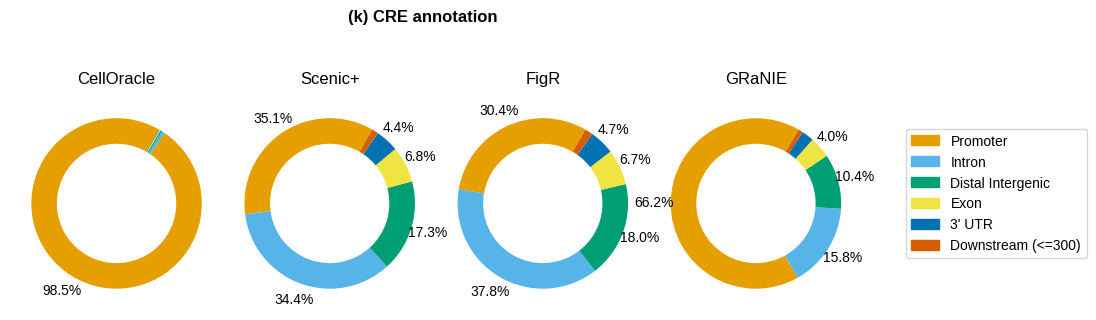

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, len(peak_annotation_df.index), figsize=(11, 4))
startangle = 60

# Iterate over pie charts
for i, (ax, idx) in enumerate(zip(axes, peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=10)
    counts = peak_annotation_df.loc[idx]
    wedges, _ = ax.pie(counts, colors=colors_blind, wedgeprops=dict(width=0.3), startangle=startangle)

    for j, wedge in enumerate(wedges):
        if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
            continue
        # Calculate angle and position for the annotation
        ang = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),
                    ha="center", va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="none", ec="none"))

# Adjust spacing and add legend
plt.subplots_adjust(wspace=0)

# Create a single legend outside the pie charts
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors_blind, peak_annotation_df.columns)]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.11, 0.52), fontsize=10)

fig.suptitle('(k) CRE annotation', fontsize=12, fontweight='bold')
# Save figure
fig.savefig(f'{RESULTS_DIR}/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()